# Titanic Machine Learning from Disaster

NOTE: All the analysis for this notebook is done with [Tableau](https://www.tableau.com/).

In [1]:
import re                                                                         # Regex
import numpy as np                                                                # Linear Algebra
import pandas as pd                                                               # For DataFrame

# Models
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from xgboost import XGBClassifier

from sklearn.preprocessing import LabelEncoder, OneHotEncoder                     # Encoders
from sklearn.model_selection import train_test_split, cross_validate              # Tools
from sklearn.ensemble import RandomForestClassifier                               # Random forest
from sklearn.tree import DecisionTreeClassifier                                   # Decision Tree
from sklearn.svm import SVC, LinearSVC                                            # Support vector machines
from sklearn.linear_model import Perceptron, SGDClassifier, LogisticRegression    # More models
from sklearn.neighbors import KNeighborsClassifier                                # K-Nearest Neighbors model
from sklearn.naive_bayes import GaussianNB                                        # Gaussian model
from xgboost import XGBClassifier                                                 # XGBoost model
from sklearn.impute import SimpleImputer                                          # Imputer

path = '/content/drive/MyDrive/Kaggle/Titanic-Machine-Learning-from-disaster/datasets'

## Load Dataset

In [2]:
train_df = pd.read_csv(f'{path}/raw/train.csv')
test_df = pd.read_csv(f'{path}/raw/test.csv')    
combine = [train_df, test_df]

train_df.head()

PassengerId  Survived  Pclass  ...     Fare Cabin  Embarked
0            1         0       3  ...   7.2500   NaN         S
1            2         1       1  ...  71.2833   C85         C
2            3         1       3  ...   7.9250   NaN         S
3            4         1       1  ...  53.1000  C123         S
4            5         0       3  ...   8.0500   NaN         S

[5 rows x 12 columns]

## Exploratory Data Analysis (EDA)

In [3]:
# All features
print('All feafures:', list(combine[0].columns))

# Ordinal features
print('Ordinal features:', list(combine[0].select_dtypes(exclude = ['object']).columns))

# Categorical features
print('Categorical features:', list(combine[0].select_dtypes(include = ['object']).columns))

All feafures: ['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']
Ordinal features: ['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
Categorical features: ['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']


### Age Over Survived
By looking at the **Age** vs **Survived** analysis below, we can interpinterpret:
- Most passengers onboard are men.
- Most men and women are in their late 20s; However, most are men.
- We could turn **Age** to smaller bins (Why? there isn't really a difference between 21 and 21 year-olds)

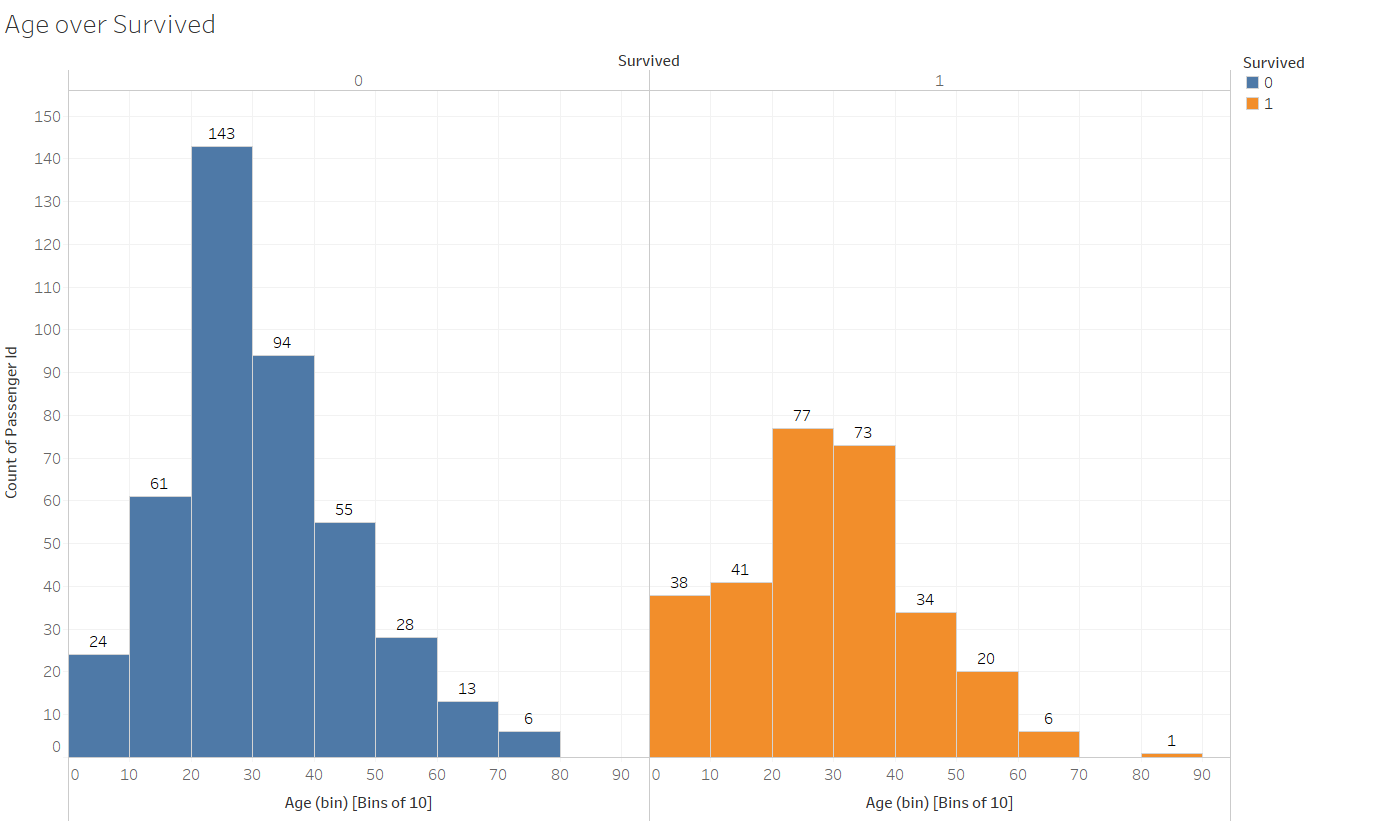

In [4]:
for df in combine:

  # Fix Age
  df['Age'].fillna(value = df['Age'].median(), inplace = True)

  # Create 'AgeBin'
  df['AgeBin'] = pd.cut(df['Age'].astype(int), 5).values.astype(str)

  # Remove Age
  df.drop(columns = ['Age'], inplace = True)

### Sex over Survived

We can understand the followings from the analysis below:
- Most men have not survived and most women have survived.
- **Sex** has an important role in predicting survival rate of the passengers.

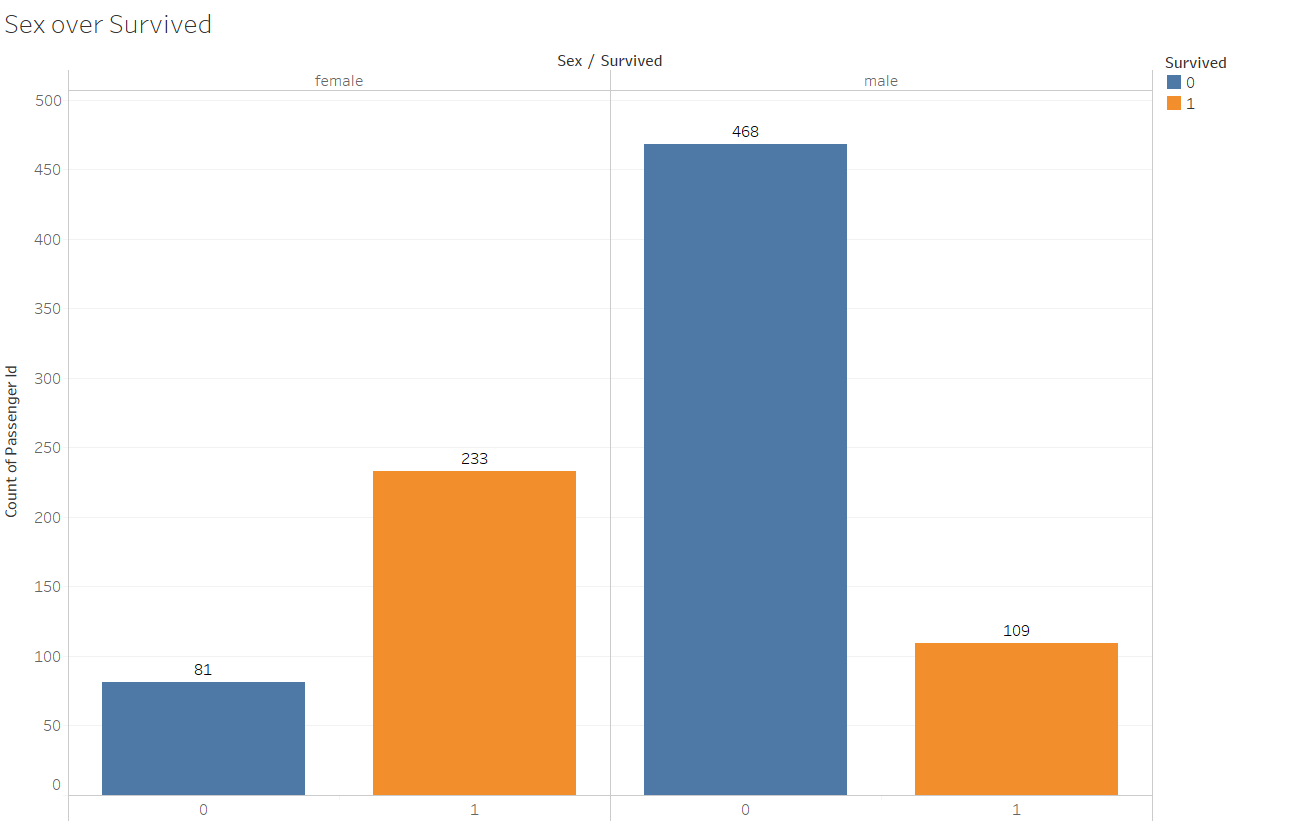

### Embarked over Survived

According to our statistics below, it is clear that:
- Most passengers embarked from port **C** have survived; However, this is not the case for port **Q**.
- Most passengers have embarked from port **S**. why? This can be related to the **PClass** feature.
- We have some **NULLs** in the dataset!

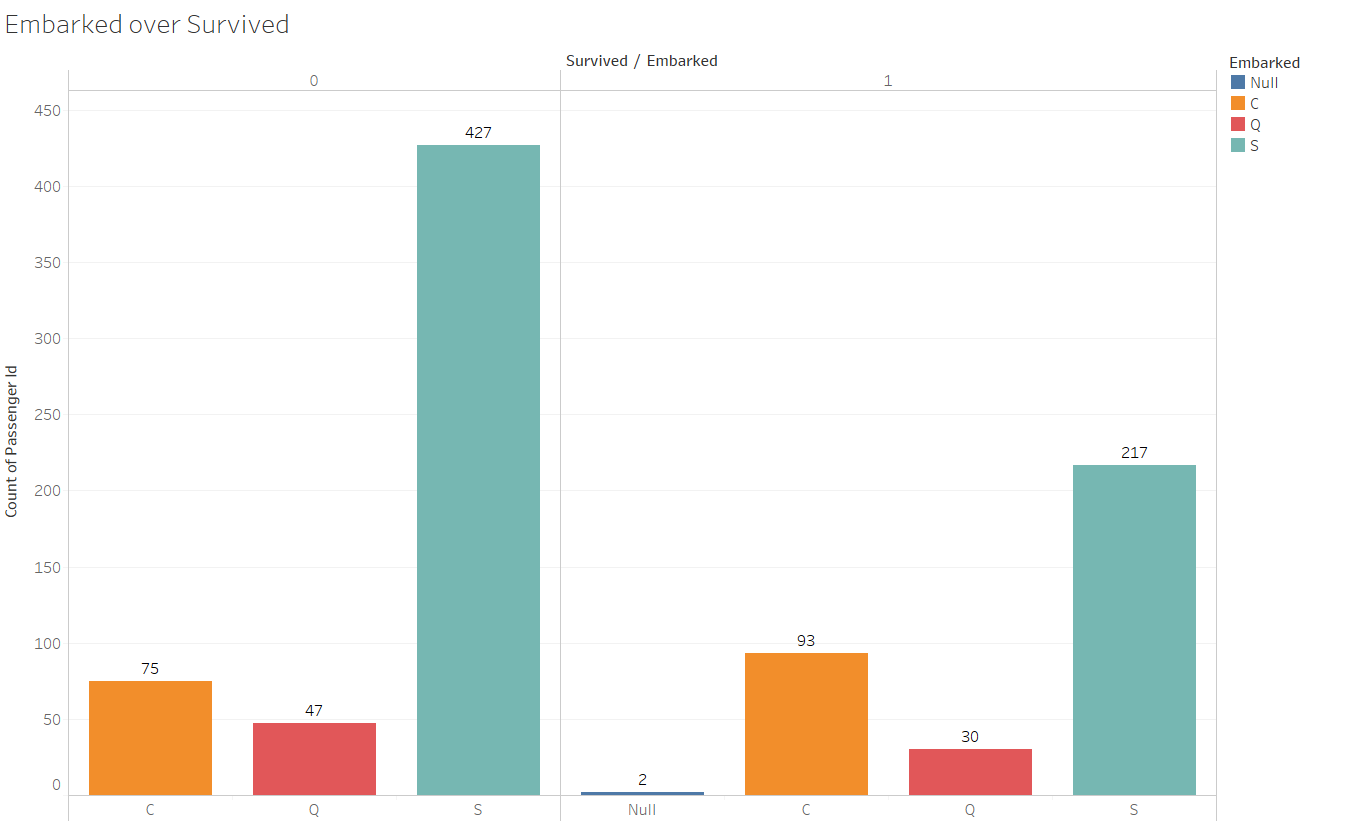

In [5]:
# Fix 'Embakred' missing values
for df in combine:
  imputer = SimpleImputer(missing_values = np.nan, strategy = 'most_frequent')
  df['Embarked'] = imputer.fit_transform(df['Embarked'].to_numpy().reshape(-1,1))

### FamilySize over Survived

The features **SibSp** and **Parch** are useful, but not in their raw forms. Logically speaking, you don't choose between your sibling or your parent in the middle of life and death crisis. So we better do a *Feature Extraction* and create a new feature called **FamilySize** with this formula:
`[Parch] + [SibSp] + 1`

If we don't add the `+1`, data wouldn't make sense beacuse each family requires atleast one member. Moreover:
- Families of size larger than 5 are not likely to have survived.
- If the person is alone, it's much less likely to have survived (2 out of every 3 alone people have died)
- The rate of death/survived decreases as the familySize increases (Portions become more balanced).
- FamilySizes of 2, 3 and 4 are more likely to survive!

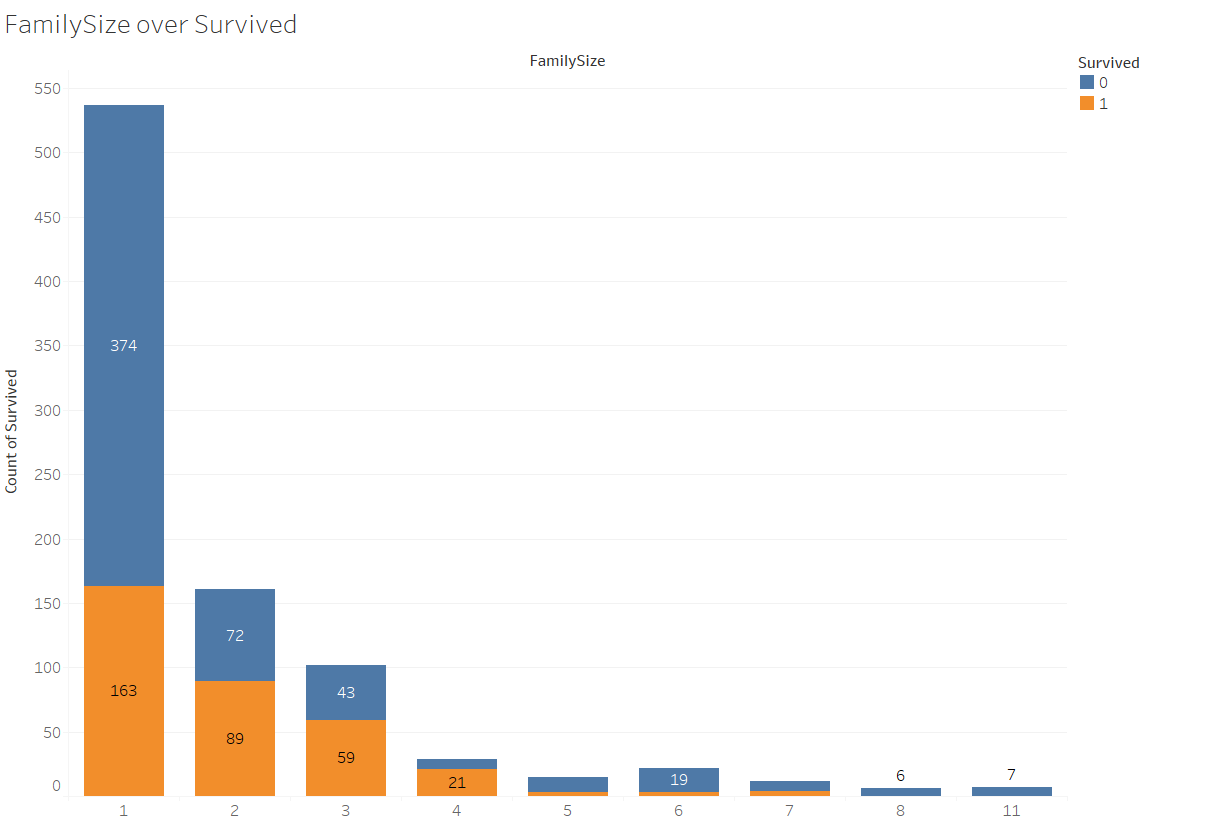

In [6]:
for df in combine:
  # Create 'FamilySize' feature
  df['FamilySize'] = df['Parch'] + df['SibSp'] + 1

  # Create 'IsAlone' feature
  df['IsAlone'] = (df['FamilySize'] == 1).astype(int)

### Cabin, Ticket and Name


The two features **Cabin** and **Ticket** con't provide any useful infomation to our model and some are missing a lot of data. So best way to approch this is to simply remove them both. But for the **Name** feature we could extract titles and drop the original feature.

In [7]:
min_count = 10

for df in combine:

  # Title
  df['Title'] = df['Name'].apply(lambda name: re.search(r'([A-Za-z]+)\.', name).group(0))

  title_names = (df['Title'].value_counts() < min_count)
  df['Title'] = df['Title'].apply(lambda x: 'Rare' if title_names.loc[x] == True else x)

  # Drop features
  df.drop(columns = ['Cabin', 'Ticket', 'Name'], inplace = True)

### Fare and Pclass over Survival

**Fare** is definitely related to **Pclass** but if we print the umber of unique fares, it would be *248*. This means there is another parameter in place and that's the **FamilySize**. The more family members the higher the cost.

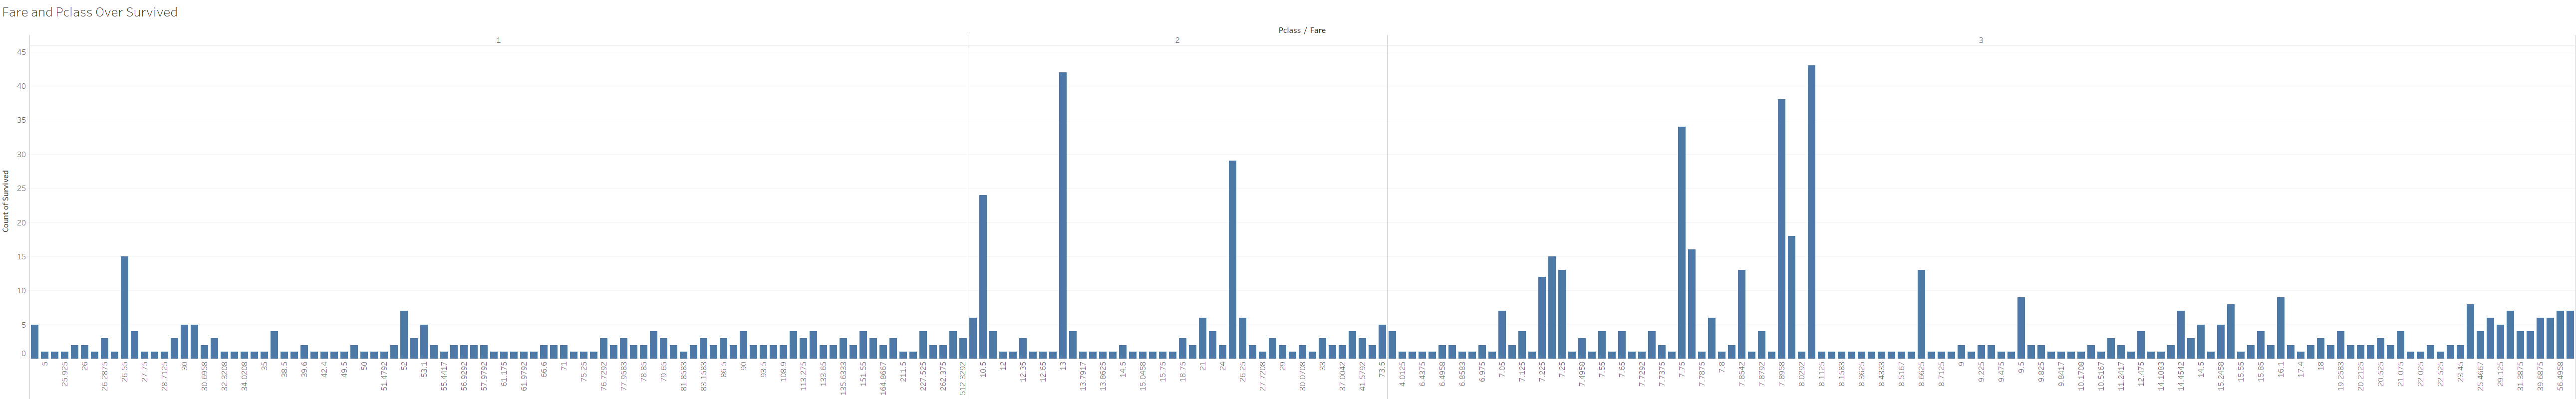

In [8]:
for df in combine:

  # Fix Fare
  df['Fare'].fillna(value = df['Fare'].median(), inplace = True)

  # FareBin
  df['FareBin'] = pd.qcut(df['Fare'], 4).values.astype(str)

  # Drop Fare
  df.drop(columns = ['Fare'], inplace = True)

## Modeling

### Encode Data

In [9]:
ordinal_features = ['Sex', 'AgeBin', 'FareBin']
categorical_features = ['Embarked', 'Title']
join_feature = ['PassengerId']

encoder = LabelEncoder()

for df in combine:

  # Encode ordinal features
  for feature in ordinal_features:    
    df[feature] = encoder.fit_transform(df[feature])

# Encode categorical features
dummies = pd.get_dummies(train_df[categorical_features + join_feature])
train_df = pd.merge(train_df, dummies, on = "PassengerId")
train_df.drop(columns = categorical_features, inplace = True)

dummies = pd.get_dummies(test_df[categorical_features + join_feature])
test_df = pd.merge(test_df, dummies, on = "PassengerId")
test_df.drop(columns = categorical_features, inplace = True)

### Splitting Data

In [10]:
print('Features:', list(train_df.columns))
train_df.head()

Features: ['PassengerId', 'Survived', 'Pclass', 'Sex', 'SibSp', 'Parch', 'AgeBin', 'FamilySize', 'IsAlone', 'FareBin', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Title_Master.', 'Title_Miss.', 'Title_Mr.', 'Title_Mrs.', 'Title_Rare']


PassengerId  Survived  Pclass  ...  Title_Mr.  Title_Mrs.  Title_Rare
0            1         0       3  ...          1           0           0
1            2         1       1  ...          0           1           0
2            3         1       3  ...          0           0           0
3            4         1       1  ...          0           1           0
4            5         0       3  ...          1           0           0

[5 rows x 18 columns]

In [11]:
# Split Data
features = ['Pclass', 'Sex', 'AgeBin', 'FamilySize', 'IsAlone', 'FareBin', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Title_Master.', 'Title_Miss.', 'Title_Mr.', 'Title_Mrs.', 'Title_Rare']
target = 'Survived'

train_x = train_df[features]
train_y = train_df[target]
test_x = test_df[features]

### K-Fold Cross Validation

In [12]:
def k_fold(_model):
    return round(cross_validate(_model, train_x, train_y, cv = 5)['test_score'].mean() * 100)

### Find Best Model

In [13]:
MLA = {
    # Ensemble Methods
    'AdaBoostClassifier': ensemble.AdaBoostClassifier(),
    'BaggingClassifier': ensemble.BaggingClassifier(),
    'ExtraTreesClassifier': ensemble.ExtraTreesClassifier(),
    'GradientBoostingClassifier': ensemble.GradientBoostingClassifier(),
    'RandomForestClassifier': ensemble.RandomForestClassifier(),

    # Gaussian Processes
    'GaussianProcessClassifier': gaussian_process.GaussianProcessClassifier(),
    
    # GLM
    'LogisticRegressionCV': linear_model.LogisticRegressionCV(max_iter = 1000),
    'PassiveAggressiveClassifier': linear_model.PassiveAggressiveClassifier(),
    'RidgeClassifierCV': linear_model.RidgeClassifierCV(),
    'SGDClassifier': linear_model.SGDClassifier(),
    'Perceptron': linear_model.Perceptron(),
    
    # Navies Bayes
    'BernoulliNB': naive_bayes.BernoulliNB(),
    'GaussianNB': naive_bayes.GaussianNB(),
    
    # Nearest Neighbor
    'KNeighborsClassifier': neighbors.KNeighborsClassifier(),
    
    # SVM
    'SVC': svm.SVC(probability = True),
    'NuSVC': svm.NuSVC(probability = True),
    'LinearSVC': svm.LinearSVC(),
    
    # Trees    
    'DecisionTreeClassifier': tree.DecisionTreeClassifier(),
    'ExtraTreeClassifier': tree.ExtraTreeClassifier(),
    
    # Discriminant Analysis
    'LinearDiscriminantAnalysis': discriminant_analysis.LinearDiscriminantAnalysis(),
    'QuadraticDiscriminantAnalysis': discriminant_analysis.QuadraticDiscriminantAnalysis(),

    # XGBoost
    'XGBClassifier': XGBClassifier()    
}

# Calculate accuracies
accuracies = []
for name, model in MLA.items():
  accuracy = k_fold(model)
  accuracies.append(accuracy)

# Create DataFrame
accuracy_df = pd.DataFrame(data = accuracies, index = MLA.keys(), columns = ['Accuracy']).sort_values(by = 'Accuracy', ascending = False)
accuracy_df

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarn

Accuracy
LinearDiscriminantAnalysis           83
LogisticRegressionCV                 83
LinearSVC                            83
RidgeClassifierCV                    83
NuSVC                                83
SVC                                  83
GradientBoostingClassifier           82
GaussianProcessClassifier            82
BaggingClassifier                    82
AdaBoostClassifier                   81
KNeighborsClassifier                 81
DecisionTreeClassifier               81
XGBClassifier                        81
RandomForestClassifier               81
ExtraTreesClassifier                 81
ExtraTreeClassifier                  80
SGDClassifier                        79
PassiveAggressiveClassifier          79
BernoulliNB                          79
GaussianNB                           78
Perceptron                           75
QuadraticDiscriminantAnalysis        66

## Final Model and Submission

In [14]:
# Make prediction
model = MLA[accuracy_df.index[0]]
model.fit(train_x, train_y)
pred = model.predict(test_x)

# Submission
submission_df = pd.DataFrame(data = {'PassengerId': test_df['PassengerId'], 'Survived': pred})
submission_df.to_csv(f'{path}/processed/submission.csv', index = False)
submission_df.head()

PassengerId  Survived
0          892         0
1          893         1
2          894         0
3          895         0
4          896         1